In [1]:
# Multi-Step Ahead Time Series Prediction: Univariate Case

# The best two performing DL models for the crypto datasets are
    # BTC (BD-LSTM, Conv-LSTM)
    # ETH (LSTM, BD-LSTM)
# The information is given from our related work, which can be found here: 
    # Paper: https://arxiv.org/abs/2405.11431
    # GitHub Repo: https://github.com/sydney-machine-learning/deeplearning-crypto

# So, let's implement those and then implement our quantile version

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.optim as optim
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 

In [3]:
# Define Functions
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

In [4]:
# Data Handling - should be the same as our linear version
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()

In [5]:
Close_Price = np.array(Close_Price)
Close_Price_reshaped = Close_Price.reshape(-1, 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled_2D = scaler.fit_transform(Close_Price_reshaped)
Closed_Price_scaled = Close_Price_scaled_2D.flatten()

In [7]:
# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [8]:
# scaling the data makes all the difference (loss: 0.0001 vs 239499328)
X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

In [9]:
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [10]:
train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [12]:
# Best Performing Model: Bi-directional Long-Short Term Memory Model (BD-LSTM)
class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

In [14]:
# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [15]:
# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.007696
Epoch [10/50], Loss: 0.000053
Epoch [20/50], Loss: 0.000023
Epoch [30/50], Loss: 0.000013
Epoch [40/50], Loss: 0.000010
Epoch [50/50], Loss: 0.000009


In [16]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
predicted_values = scaler.inverse_transform(y_pred)
y_test = np.concatenate(y_test, axis=0)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[3919.5078  3905.0117  3765.8303 ]
 [9500.513   9541.296   9469.577  ]
 [ 499.19482  445.66644  279.70224]
 ...
 [8019.569   8042.5464  7932.286  ]
 [ 299.86786  243.92572   76.73696]
 [ 392.47052  337.619    170.79933]]
True values: [[ 4278.846    4017.2686   4214.672  ]
 [ 9888.61    10233.6     10975.6    ]
 [  465.321     454.934     456.078  ]
 ...
 [ 8192.494    8144.1943   8827.765  ]
 [  257.321     234.825     233.84299]
 [  320.046     328.206     352.68402]]


In [17]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 368.1753, MAPE on test set: 16.7554%


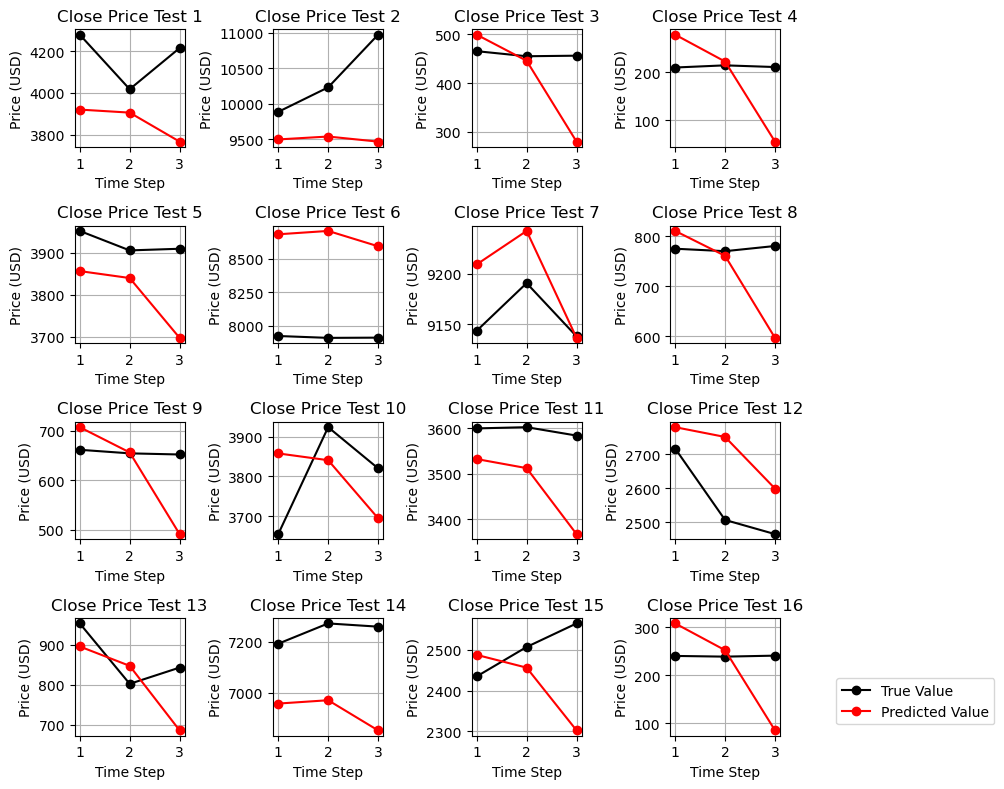

In [18]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [19]:
## BD-LSTM: Quantile Version (Univariate)

In [20]:
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()

Close_Price = np.array(Close_Price)
Close_Price_reshaped = Close_Price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled_2D = scaler.fit_transform(Close_Price_reshaped)
Closed_Price_scaled = Close_Price_scaled_2D.flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [21]:
class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

In [22]:
# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [23]:
# Hyperparameters
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict
output_size = 3

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [24]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.055563
Epoch [10/50], Loss: 0.002785
Epoch [20/50], Loss: 0.002308
Epoch [30/50], Loss: 0.002156
Epoch [40/50], Loss: 0.002103
Epoch [50/50], Loss: 0.002070


In [25]:
def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)  # Adjust dimensions if necessary
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

In [26]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)

In [27]:
predicted_values = predicted_values.numpy()
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = actual_values.numpy()[:, :, 0]
actual_values = scaler.inverse_transform(actual_values)

In [28]:
predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

In [29]:
# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [4278.846  4017.2686 4214.672 ]
At Quantile 0.05: [3366.3938 3378.3777 3261.8782]
At Quantile 0.25: [3830.2466 3789.1155 3761.0833]
At Quantile 0.5: [4021.9626 3956.6208 3963.3958]
At Quantile 0.75: [4089.143  4100.1865 4129.5522]
At Quantile 0.95: [4344.8765 4488.1313 4671.796 ]
Actual Values: [ 9888.61 10233.6  10975.6 ]
At Quantile 0.05: [8244.609 8225.402 8156.357]
At Quantile 0.25: [9169.952 9076.06  9040.09 ]
At Quantile 0.5: [9502.473 9439.199 9472.518]
At Quantile 0.75: [9732.018 9864.635 9951.258]
At Quantile 0.95: [10417.099 10647.131 11059.02 ]
Actual Values: [465.321 454.934 456.078]
At Quantile 0.05: [196.78607 184.75981 243.20686]
At Quantile 0.25: [411.99783 352.90796 332.33643]
At Quantile 0.5: [467.61575 414.88278 427.58652]
At Quantile 0.75: [443.65906 469.1794  455.6793 ]
At Quantile 0.95: [549.4271 542.4152 651.9212]
Actual Values: [210.33899 214.861   211.315  ]
At Quantile 0.05: [ -8.831826 -23.726692  50.176

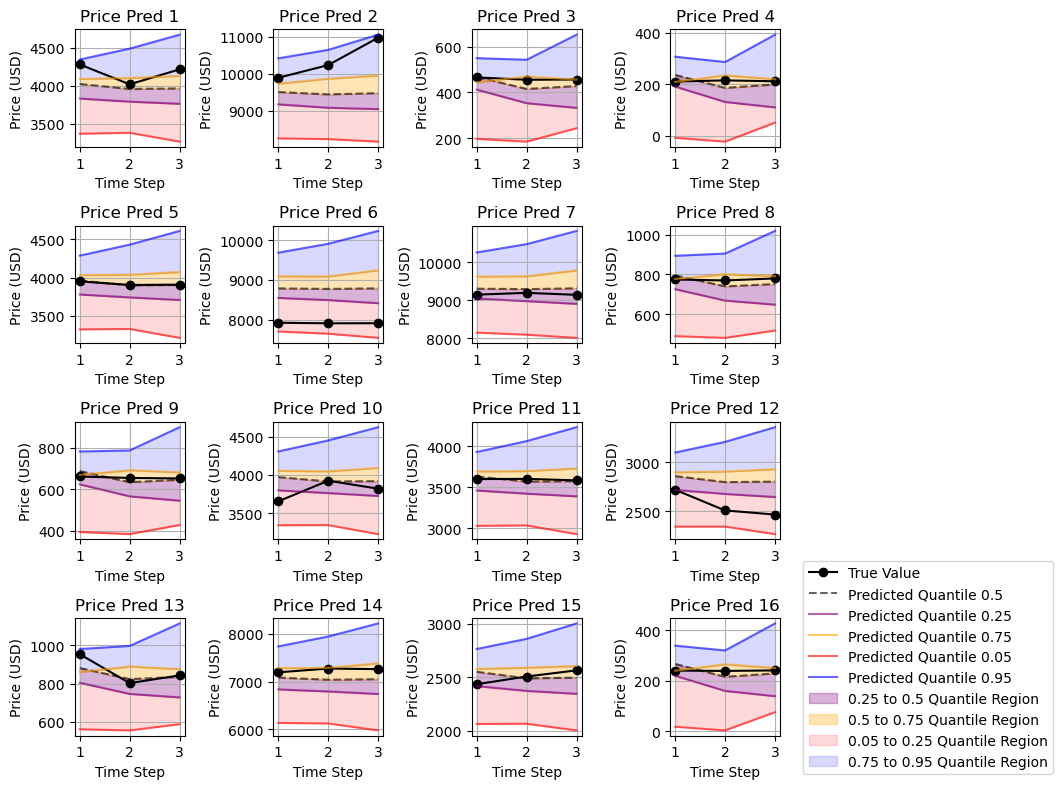

In [30]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [31]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Performance
MAE: 344.5122, MAPE: 6.9203%


In [32]:
## Second Best Performing Model: Convolutional Long-Short Term Memory Model (Conv-LSTM)